In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
img_height = 224
img_width = 224
batch_size = 256

In [3]:
test_directory = "/Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/dataset/Espectrogramas/multibalance_para_test/ns=32_sol=0.9_off_f=0-40"
test_ds= tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', batch_size=batch_size, image_size=(img_height, img_width), seed=123)

Found 11008 files belonging to 3 classes.


2024-02-08 17:50:01.535334: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-08 17:50:01.535358: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-08 17:50:01.535361: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-08 17:50:01.535555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-08 17:50:01.535571: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
def resize_images(image, label):
    # Redimensionar la imagen para que se ajuste al tamaño de entrada del primer modelo
    image_resized_model = tf.image.resize(image, (299,299))
    
    return image_resized_model, label

# Redimensionar las imágenes del conjunto de datos de prueba
test_ds_resized = test_ds.map(resize_images)

In [5]:
# Esta parte se usa para generar datos para pruebas. Si se tienen datos específicos para las pruebas, se deben llamar con el nombre de test_ds
class_names = test_ds.class_names
print(class_names)

'''test_size = num_elements - train_size
test_ds = train_ds.take(test_size)
train_ds = train_ds.skip(test_size)'''

print(f'test size:{len(test_ds)}')

['LP', 'VLP', 'VT']
test size:43


# Modelo ResNet 50

In [6]:
num_classes = len(class_names)

In [7]:
ruta_modelos_entrenados = '/Volumes/SSD_ANDRÉS/Modelos entrenados'
Resnet_model = tf.keras.models.load_model(ruta_modelos_entrenados+'/resnet_RegOpt_adasyn_224_bs256NDO_DATAyruido_decay20epoc')
#Densenet_model = tf.keras.models.load_model(ruta_modelos_entrenados+'/densenet_RegOpt_adasyn_224_bs256DO05_L200001L2000001_decay5epoc')
Inception_model = tf.keras.models.load_model(ruta_modelos_entrenados+'/Inception_RegOpt_224_bs256NDO_L2000001L2000001_decay10epoc')
Efficient_model = tf.keras.models.load_model(ruta_modelos_entrenados+'/Efficient_RegOpt_224_bs256NDO_L2000001L2000001_09decay20epoc')


modelos_entrenados= [Efficient_model, Inception_model, Resnet_model]


In [8]:
# Evaluar el modelo en el conjunto de prueba
for modelo in modelos_entrenados:
    test_loss, test_acc = modelo.evaluate(test_ds)
    print(f'Precisión en el conjunto de prueba: {test_acc}')

2024-02-08 17:50:13.428107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 87s 2s/step - loss: 0.1602 - accuracy: 0.9450
Precisión en el conjunto de prueba: 0.9450399875640869


2024-02-08 17:51:40.768611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 62s 1s/step - loss: 0.1999 - accuracy: 0.9556
Precisión en el conjunto de prueba: 0.9555777311325073


2024-02-08 17:52:42.428049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 104s 2s/step - loss: 0.0606 - accuracy: 0.9812
Precisión en el conjunto de prueba: 0.9811955094337463


In [9]:
y_pred = []  # store predicted labels
y_true = []  # store true labels


for image_batch, label_batch in test_ds:
   
   y_true.append(label_batch)
   
   predicciones = [modelo.predict(image_batch) for modelo in modelos_entrenados]
   pred_promedio = np.mean(predicciones, axis=0)
   
   y_pred.append(np.argmax(pred_promedio, axis = - 1))
   

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2024-02-08 17:54:28.505288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 3s 201ms/step


2024-02-08 17:54:31.513243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 2s 146ms/step


2024-02-08 17:54:33.654622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 2s 314ms/step


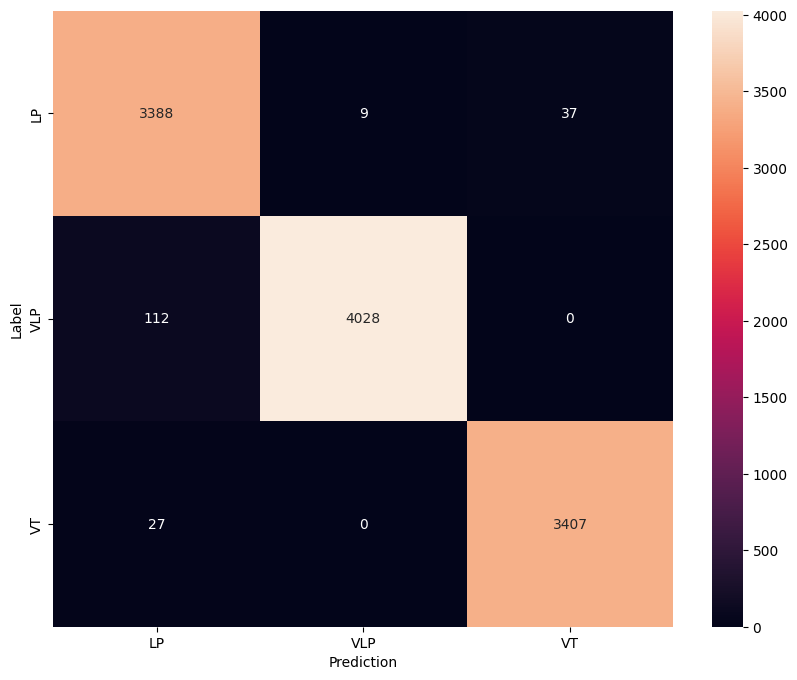

In [10]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

resnet 98.12%
%LP: 97.96156086196855
%VLP: 97.6328502415459
%VT: 98.86429819452533

resnet 98.12% + inception 95.56%
%LP: 98.45661036691904
%VLP: 97.19806763285024
%VT: 98.66045428072219

resnet 98.12% + inception 95.56% + efficient 94.50%
%LP: 98.66045428072219
%VLP: 97.29468599033815
%VT: 99.21374490390215

In [11]:
cm = confusion_matrix(correct_labels, predicted_labels)
print('%LP: '+str(cm[0][0]/sum(cm[0]) * 100))
print('%VLP: '+str(cm[1][1]/sum(cm[1]) * 100))
print('%VT: '+str(cm[2][2]/sum(cm[2]) * 100))

%LP: 98.66045428072219
%VLP: 97.29468599033815
%VT: 99.21374490390215


In [13]:
from sklearn.metrics import classification_report
print(classification_report(correct_labels, predicted_labels, digits=4))

              precision    recall  f1-score   support

           0     0.9606    0.9866    0.9734      3434
           1     0.9978    0.9729    0.9852      4140
           2     0.9893    0.9921    0.9907      3434

    accuracy                         0.9832     11008
   macro avg     0.9825    0.9839    0.9831     11008
weighted avg     0.9835    0.9832    0.9832     11008

